In [1]:
import gzip
import struct
import numpy as np
import matplotlib.pyplot as plt

1. Перших 2 байти завжди порожні тому ми їх пропускаємо зчитуючи >H тип unsigned short який займає 2 байти

2. 3-ій байт вказує на тип даних
  * 0x08: unsigned byte 
  * 0x09: signed byte 
  * 0x0B: short (2 bytes) 
  * 0x0C: int (4 bytes) 
  * 0x0D: float (4 bytes) 
  * 0x0E: double (8 bytes)
  
3. Наступний байт вказує кількість вимірів матриці

4. Далі послідовно для кожного виміру вказано його розмір як 4-байтове ціле число. Тобто, починаючи з п’ятого байту, три групи по 4 байти вказують на розмірність тривимірної матриці, а саме

In [2]:
print('Labels shape')

with gzip.open('dataset/train-labels-idx1-ubyte.gz', 'rb') as f:
    print(struct.unpack('>HBB', f.read(4)))
    print(struct.unpack('>I', f.read(4)))

print('\nImages shape')
with gzip.open('dataset/train-images-idx3-ubyte.gz', 'rb') as f:
    print(struct.unpack('>HBB', f.read(4)))
    print(struct.unpack('>III', f.read(12)))
    
    

Labels shape
(0, 8, 1)
(60000,)

Images shape
(0, 8, 3)
(60000, 28, 28)


In [3]:
# script for reading MNIST file format
def read_idx(filename):
    with gzip.open(filename, 'rb') as f:
        zero, data_type, dims = struct.unpack('>HBB', f.read(4))
        shape = tuple(struct.unpack('>I', f.read(4))[0] for d in range(dims))
        return np.frombuffer(f.read(), dtype=np.uint8).reshape(shape)

In [4]:
raw_train = read_idx('dataset/train-images-idx3-ubyte.gz')
X_train = raw_train.reshape(60000, 28 * 28)
y_train = read_idx('dataset/train-labels-idx1-ubyte.gz')

raw_test = read_idx('dataset/t10k-images-idx3-ubyte.gz')
X_test = raw_test.reshape(10000, 28 * 28)
y_test = read_idx('dataset/t10k-labels-idx1-ubyte.gz')

In [5]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

/usr/local/lib/python3.5/dist-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype uint8 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [7]:
import pandas as pd

def get_subset(X, y, n):
    df = pd.DataFrame(data=X)
    df['label'] = y
    df = df.groupby('label').apply(pd.DataFrame.sample, n=n).reset_index(drop=True)
    
    return df.iloc[:, :-1].copy(), df.label.copy()

In [8]:
X_subset, y_subset = get_subset(X_train_scaled, y_train, 100)

In [9]:
from sklearn.svm import LinearSVC

In [26]:
%time LinearSVC(C=0.001, verbose=True, dual=False, max_iter=1000000).fit(X_subset, y_subset)

[LibLinear]CPU times: user 3.42 s, sys: 0 ns, total: 3.42 s
Wall time: 3.5 s


LinearSVC(C=0.001, class_weight=None, dual=False, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=True)

In [10]:
from sklearn.model_selection import cross_val_score

parameters = np.power(10.0, np.arange(-5, 5))
scores = []

for c in parameters:
    svc = LinearSVC(C=c, verbose=True, dual=False, max_iter=1000000)
    score = cross_val_score(svc, X_subset, y_subset, cv=5, scoring='accuracy').mean()
    scores.append(score)
    print(c, scores[-1])

[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]1e-05 0.788
[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]0.0001 0.839
[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]0.001 0.842
[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]0.01 0.83
[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]0.1 0.801
[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]1.0 0.779
[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]10.0 0.767
[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]100.0 0.745
[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]1000.0 0.746
[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]10000.0 0.744


0.842 0.001


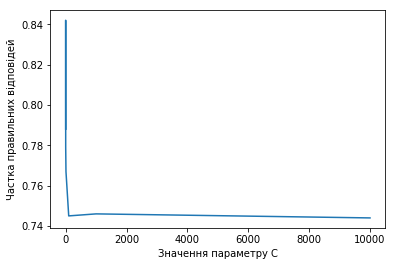

In [13]:
plt.plot(parameters, scores)

# plt.xticks(parameters)

plt.xlabel('Значення параметру C')
plt.ylabel('Частка правильних відповідей')

xmax = max(scores)
xindex = scores.index(xmax)
print(xmax, parameters[xindex])

In [19]:
%time svm = LinearSVC(C=0.001, verbose=True, dual=False, max_iter=1000000).fit(X_train_scaled, y_train)

[LibLinear]CPU times: user 7min 22s, sys: 60 ms, total: 7min 22s
Wall time: 7min 22s


In [20]:
%time y_pred = svm.predict(X_test_scaled)

CPU times: user 120 ms, sys: 36 ms, total: 156 ms
Wall time: 145 ms


In [21]:
from sklearn.metrics import accuracy_score

accuracy_score(y_test, y_pred)

0.90869999999999995

In [22]:
import itertools

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Нормалізована матриця помилок")
    else:
        print('Матриця помилок, без нормалізації')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('Вірний клас')
    plt.xlabel('Передбачений клас')

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)

Матриця помилок, без нормалізації
[[ 961    0    1    1    0    6    6    2    2    1]
 [   0 1106    3    2    1    2    4    1   16    0]
 [  11   18  898   16   11    5   16   15   37    5]
 [   5    4   22  912    3   20    4   14   21    5]
 [   1    6    4    1  916    1   10    4    8   31]
 [  12    6    0   35   14  755   23   14   24    9]
 [  10    7    7    1    7   17  907    1    1    0]
 [   3   17   18    5    9    0    2  936    3   35]
 [  12   22    9   17   16   36   14   16  822   10]
 [  12    7    1   18   47   11    0   33    6  874]]


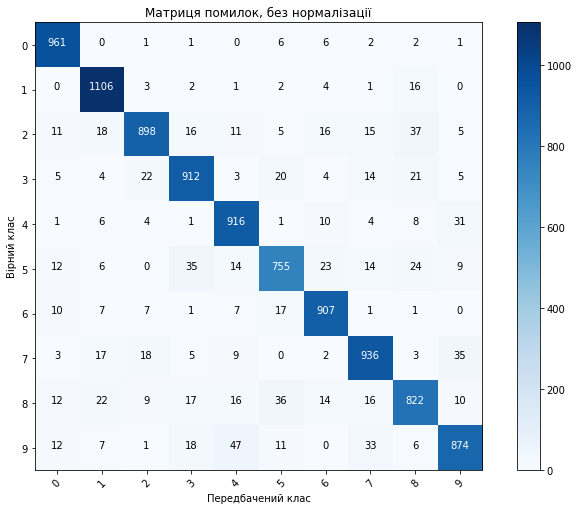

In [23]:
# Plot non-normalized confusion matrix
plt.figure(figsize=(10, 7))
plot_confusion_matrix(cnf_matrix, classes=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
                      title='Матриця помилок, без нормалізації')

In [25]:
# save classifier
from sklearn.externals import joblib
joblib.dump(svm , 'app/classifiers/svm.pkl') 

['app/classifiers/svm.pkl']